In [1]:
import torch
import torch.optim as optim
import torch.utils.data
import torch.backends.cudnn as cudnn
from torch.utils.data import random_split
from torch.utils.data.dataset import Dataset
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import os

import numpy as np
from sklearn.model_selection import train_test_split

In [2]:
import torchvision
from torchvision import transforms, datasets

In [39]:
# Parse file nums to dicts
images_file_path = os.getcwd() + '/../data/images'
image_ids = []
for file in os.listdir(images_file_path):
    filename = os.fsdecode(file)
    image_ids.append(filename[2:-4])

train_ids, dev_ids = train_test_split(image_ids, test_size=0.2)

In [73]:
#--- hyperparameters ---
N_EPOCHS = 20
BATCH_SIZE_TRAIN = 128
BATCH_SIZE_DEV = 16
LR = 0.001

In [6]:
NUM_CLASSES = 14
DATA_DIR = os.getcwd() + '/../data/'

In [42]:
from collections import defaultdict

class ProjectDataset(Dataset):
    def __init__(self, image_folder, annotation_folder, selected_keys=None, transform=None, target_transform=None):
        data = {key: {'file': f'im{key}.jpg', 'labels': []} for key in selected_keys}
        self.data = []
        self.classes = []

        for file in os.listdir(annotation_folder):
            filename = os.fsdecode(file)
            cls = filename.split('.')[0]
            self.classes.append(cls)
            file_path = os.path.join(annotation_folder, filename)
            
            with open(file_path, 'r') as f:
                for line in f.readlines():
                    idx = line.replace('\n', '')
                    if not selected_keys or idx in selected_keys:
                        data[idx]['labels'].append(cls)
        
        for key, val in data.items():
            filename = val['file']
            labels = torch.Tensor([x in val['labels'] for x in self.classes])
            self.data.append({'file': filename, 'labels': labels})
        
        self.image_folder = image_folder
        self.transform = transform
        self.target_transform = target_transform
    
    def __getitem__(self, item):
        data = self.data[item]
        labels = data['labels']
        image_path = os.path.join(self.image_folder, data['file'])
        image = torchvision.io.read_image(image_path, torchvision.io.ImageReadMode.RGB)
        image = image.type(torch.FloatTensor)
        image = torch.div(image, 255)
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            labels = self.target_transform(labels)
            
        return image, labels
    
    def __len__(self):
        return len(self.data)

In [43]:
# We transform image files' contents to tensors
# Plus, we can add random transformations to the training data if we like
# Think on what kind of transformations may be meaningful for this data.
# Eg., horizontal-flip is definitely a bad idea for sign language data.
# You can use another transformation here if you find a better one.
train_transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                      #transforms.RandomPerspective(distortion_scale=0.2),
                                      #transforms.ColorJitter(),
                                      #transforms.ToTensor()
                                     ])
dev_transform = transforms.Compose([])

annotation_path = DATA_DIR + 'annotations'
image_path = DATA_DIR + 'images'
train_set = ProjectDataset(image_path, annotation_path, selected_keys=train_ids, transform=train_transform)
dev_set = ProjectDataset(image_path, annotation_path, selected_keys=dev_ids, transform=dev_transform)
# test_set  = datasets.ImageFolder(DATA_DIR % 'test',  transform=test_transform)


# Create Pytorch data loaders
train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=BATCH_SIZE_TRAIN, shuffle=True)
dev_loader = torch.utils.data.DataLoader(dataset=dev_set, batch_size=BATCH_SIZE_DEV, shuffle=True)

7841 0.4900625
1983 0.49575


In [69]:
#--- model ---
class CNN(nn.Module):
    def __init__(self, num_classes=NUM_CLASSES):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=5, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
#         self.layer3 = nn.Sequential(
#             nn.Conv2d(32, 16, kernel_size=5, padding=2),
#             nn.BatchNorm2d(16),
#             nn.ReLU(),
#             nn.MaxPool2d(2)
#         )
        #self.fc = nn.Linear(4096, NUM_CLASSES)
        self.fc = nn.Linear(32768, NUM_CLASSES)
        self.sigm = nn.Sigmoid()

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        #out = self.layer3(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        out = self.sigm(out)
        return out

In [65]:
def calc_batch_metrics(targets, preds):
    t = np.asarray(targets)
    p = np.asarray(preds)
    false_neg = np.sum(np.logical_and(p == 0, t == 1))
    false_pos = np.sum(np.logical_and(p == 1, t == 0))
    true_neg = np.sum(np.logical_and(p == 0, t == 0))
    true_pos = np.sum(np.logical_and(p == 1, t == 1))
    
    recall = true_pos / (true_pos + false_pos)
    precision = true_pos / (true_pos + false_neg)
    f1_score = 2 * (precision*recall / (precision+recall))
    return precision, recall, f1_score

using gpu
 Training: Epoch 0 - Batch 124/125: Loss: 0.2270 ---
Precision:  0.3359249660619524
Recall:  0.24691582002902757
F1 Score:  0.28462383018769283
---

 Dev: Epoch 0 - Batch 249/250: Loss: 0.2085ev: Epoch 0 - Batch 86/250: Loss: 0.2099
Epoch dev loss: 52.135169081389904
Previous epoch dev loss: 1000000

---
Precision:  0.31732205077152814
Recall:  0.31930879038317056
F1 Score:  0.3183123205592311
---

 Training: Epoch 1 - Batch 124/125: Loss: 0.2063 ---
Precision:  0.3313587560162903
Recall:  0.3312769895126465
F1 Score:  0.3313178677196446
---

 Dev: Epoch 1 - Batch 249/250: Loss: 0.2035ev: Epoch 1 - Batch 30/250: Loss: 0.1998
Epoch dev loss: 50.87595587968826
Previous epoch dev loss: 52.135169081389904

---
Precision:  0.320059731209557
Recall:  0.33350622406639
F1 Score:  0.3266446532893066
---

 Training: Epoch 2 - Batch 124/125: Loss: 0.2021 ---
Precision:  0.34888312970504753
Recall:  0.3409927024908027
F1 Score:  0.34489279287522495
---

 Dev: Epoch 2 - Batch 249/250: Los

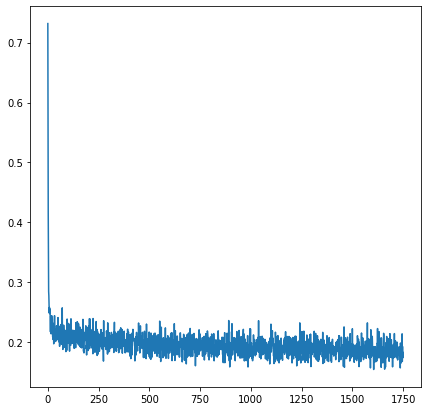

In [77]:
#--- set up ---
if torch.cuda.is_available():
    device = torch.device('cuda')
    print('using gpu')
else:
    print('using cpu')
    device = torch.device('cpu')

model = CNN().to(device)

# OPTIMIZERS & REGURALIZATION
optimizer = optim.SGD(model.parameters(), lr=LR, momentum=0.5)
loss_function = nn.BCELoss()

#--- TRAINING ---

previous_train_loss = 1000000
previous_dev_loss = 1000000

batch_losses = []

for epoch in range(N_EPOCHS):
    train_loss = 0
    train_correct = 0
    total = 0
    preds = []
    targets = []
    
    for batch_num, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        
        # Compute prediction error
        optimizer.zero_grad()
        pred = model(data)
        loss = loss_function(pred, target)

        train_loss += loss.item()
                
        batch_losses.append(loss.item())
        
        preds.extend((pred > 0.25).float().cpu().numpy())
        targets.extend(target.cpu().numpy())
        
        #total += len(target)
        #train_correct += torch.sum((pred > 0.25).float() == target) / torch.sum(target)
        
        # Backpropagation
        loss.backward()
        optimizer.step()

        print('\r', 'Training: Epoch %d - Batch %d/%d: Loss: %.4f ' % 
              (epoch, batch_num, len(train_loader), train_loss / (batch_num + 1)), end='')
        
    
    precision, recall, f1_score = calc_batch_metrics(targets, preds)
    print('---')
    print('Precision: ' , precision)
    print('Recall: ' , recall) 
    print('F1 Score: ' , f1_score)
    print('---')
    
    print()
    dev_loss = 0
    dev_total = 0
    dev_correct = 0
    
    dev_preds = []
    dev_targets = []
    
    for batch_num, (data, target) in enumerate(dev_loader):
        data, target = data.to(device), target.to(device)
               
        # Compute prediction error
        pred = model(data)
        loss = loss_function(pred, target)
        dev_loss += loss.item()
       
        #dev_total += len(target)
        #dev_correct += torch.sum((pred > 0.25).float() == target) / torch.sum(target)
    
        dev_preds.extend((pred > 0.25).float().cpu().numpy())
        dev_targets.extend(target.cpu().numpy())
       
        print('\r', 'Dev: Epoch %d - Batch %d/%d: Loss: %.4f' % 
             (epoch, batch_num, len(dev_loader), dev_loss / (batch_num + 1)), end='')
    
    print()
    print("Epoch dev loss: " + str(dev_loss))
    print("Previous epoch dev loss: " + str(previous_dev_loss))
    print()
    
    dprecision, drecall, df1_score = calc_batch_metrics(dev_targets, dev_preds)
    print('---')
    print('Precision: ' , dprecision)
    print('Recall: ' , drecall) 
    print('F1 Score: ' , df1_score)
    print('---')
    print()
    
    # EARLY STOPPING
    if dev_loss > previous_dev_loss:
        print('early stopping')
        break
        
    previous_dev_loss = dev_loss

plt.figure(figsize=(7, 7))
plt.plot(batch_losses)
plt.show()

In [14]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import numpy as np

#--- train ---
test_loss = 0
test_correct = 0
test_total = 0

test_precision = []
test_recall = []
test_f1_score = []

test_acc_all = 0

preds = []
targets = []

with torch.no_grad():
    for batch_num, (data, target) in enumerate(dev_loader):
        data, target = data.to(device), target.to(device)
        
        pred = model(data)
        loss = loss_function(pred, target)
        
        test_loss += loss.item()
        test_total += len(target)
        test_correct += torch.sum((pred > 0.5).float() == target) / torch.sum(target)
        preds.extend(pred.argmax(1).cpu().numpy())
        targets.extend(target.cpu().numpy())
        
        test_acc_all += (test_correct / total)
        
        precision, recall, f1_score = calc_batch_metrics(target, pred)
        
        test_precision.append(precision)
        test_recall.append(recall)
        test_f1_score.append(f1_score)


        print('Evaluating: Batch %d/%d: Loss: %.4f | Test Acc: %.3f%% (%d/%d)' % 
              (batch_num, len(dev_loader), test_loss / (batch_num + 1), 
               100. * test_correct / test_total, test_correct, test_total))
    
    #cf_matrix = confusion_matrix(targets, preds)
    #df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix) * 1000, 
    #                     index = [i for i in annotation_dict_train.keys()],
    #                     columns=[i for i in annotation_dict_train.keys()])
    #plt.figure(figsize=(12, 7))
    #sn.heatmap(df_cm, annot=True)

    
# print('AVG test acc:' + str(test_acc_all*100/len(dev_loader)) + '%')
print('AVG test precision:' + str(np.mean(test_precision)))
print('AVG test recall:' + str(np.mean(test_recall)))
print('AVG test f1 score:' + str(np.mean(test_f1_score)))

Evaluating: Batch 0/128: Loss: 0.2954 | Test Acc: 35.846% (5/16)
Evaluating: Batch 1/128: Loss: 0.3101 | Test Acc: 37.819% (12/32)
Evaluating: Batch 2/128: Loss: 0.2932 | Test Acc: 38.685% (18/48)
Evaluating: Batch 3/128: Loss: 0.2873 | Test Acc: 38.584% (24/64)
Evaluating: Batch 4/128: Loss: 0.2966 | Test Acc: 39.100% (31/80)
Evaluating: Batch 5/128: Loss: 0.2946 | Test Acc: 37.874% (36/96)
Evaluating: Batch 6/128: Loss: 0.2947 | Test Acc: 38.071% (42/112)
Evaluating: Batch 7/128: Loss: 0.2886 | Test Acc: 38.195% (48/128)
Evaluating: Batch 8/128: Loss: 0.2868 | Test Acc: 38.645% (55/144)
Evaluating: Batch 9/128: Loss: 0.2841 | Test Acc: 38.752% (62/160)
Evaluating: Batch 10/128: Loss: 0.2804 | Test Acc: 39.036% (68/176)
Evaluating: Batch 11/128: Loss: 0.2804 | Test Acc: 39.559% (75/192)
Evaluating: Batch 12/128: Loss: 0.2821 | Test Acc: 39.050% (81/208)
Evaluating: Batch 13/128: Loss: 0.2827 | Test Acc: 38.980% (87/224)
Evaluating: Batch 14/128: Loss: 0.2792 | Test Acc: 39.123% (93/24

Evaluating: Batch 119/128: Loss: 0.2733 | Test Acc: 39.642% (761/1920)
Evaluating: Batch 120/128: Loss: 0.2738 | Test Acc: 39.676% (768/1936)
Evaluating: Batch 121/128: Loss: 0.2735 | Test Acc: 39.672% (774/1952)
Evaluating: Batch 122/128: Loss: 0.2736 | Test Acc: 39.618% (779/1968)
Evaluating: Batch 123/128: Loss: 0.2733 | Test Acc: 39.617% (786/1984)
Evaluating: Batch 124/128: Loss: 0.2731 | Test Acc: 39.615% (792/2000)
Evaluating: Batch 125/128: Loss: 0.2735 | Test Acc: 39.622% (798/2016)
Evaluating: Batch 126/128: Loss: 0.2734 | Test Acc: 39.681% (806/2032)
Evaluating: Batch 127/128: Loss: 0.2728 | Test Acc: 39.854% (811/2036)
AVG test precision:0.5528336726490888
AVG test recall:0.5768638230102818
AVG test f1 score:0.5614790327882354
